# Tranlation Matrix Tutorial

## What is it ?

Suppose we are given a setofword pairs and their associated vector representaion $\{x_{i},z_{i}\}_{i=1}^{n}$, where $x_{i} \in R^{d_{1}}$ is the distibuted representation of word $i$ in the source language, and ${z_{i} \in R^{d_{2}}}$ is the vector representation of its translation. Our goal is to find a transformation matrix $W$ such that $Wx_{i}$ approximates $z_{i}$. In practice, $W$ can be learned by the following optimization prolem:

<center>$\min \limits_{W} \sum \limits_{i=1}^{n} ||Wx_{i}-z_{i}||^{2}$</center>

## Resources

Tomas Mikolov, Quoc V Le, Ilya Sutskever. 2013.[Exploiting Similarities among Languages for Machine Translation](https://arxiv.org/pdf/1309.4168.pdf)

Georgiana Dinu, Angelikie Lazaridou and Marco Baroni. 2014.[Improving zero-shot learning by mitigating the hubness problem](https://arxiv.org/pdf/1309.4168.pdf)

In [1]:
import os

from gensim import utils
from gensim.models import translation_matrix
from gensim.models import KeyedVectors

Using Theano backend.


For this tutorial, we'll be training our model using the English -> Italian word pairs from the OPUS collection. This corpus contains 5000 word pairs. Each pair is a English word and corresponding Italian word.

In [2]:
train_file = "OPUS_en_it_europarl_train_5K.txt"

with utils.smart_open(train_file, "r") as f:
    word_pair = [tuple(utils.to_unicode(line).strip().split()) for line in f]
print word_pair[:10]

[(u'for', u'per'), (u'that', u'che'), (u'with', u'con'), (u'are', u'are'), (u'are', u'sono'), (u'this', u'questa'), (u'this', u'questo'), (u'you', u'lei'), (u'not', u'non'), (u'which', u'che')]


This tutorial uses 300-dimensional vectors of English words as source and vectors of Italian words as target.(those vector trained by the word2vec toolkit with cbow. The context window was set 5 words to either side of the target,
the sub-sampling option was set to 1e-05 and estimate the probability of a target word with the negative sampling method, drawing 10 samples from the noise distribution)

In [3]:
# Load the source language word vector
source_word_vec_file = "EN.200K.cbow1_wind5_hs0_neg10_size300_smpl1e-05.txt"
source_word_vec = KeyedVectors.load_word2vec_format(source_word_vec_file, binary=False)

In [4]:
#Load the target language word vector
target_word_vec_file = "IT.200K.cbow1_wind5_hs0_neg10_size300_smpl1e-05.txt"
target_word_vec = KeyedVectors.load_word2vec_format(target_word_vec_file, binary=False)

training the translation matrix

In [5]:
transmat = translation_matrix.TranslationMatrix(word_pair, source_word_vec, target_word_vec)
print "the shape of translation matrix is: ", transmat.translation_matrix.shape

the shape of translation matrix is:  (300, 300)


prediction time: for any given new word, we can map it to the other language space by coputing $z = Wx$, then we find the word whose representation is closet to z in the target language space, using consine similarity as the distance metric.

In [6]:
words = [("one", "uno"), ("two", "due"), ("three", "tre"), ("four", "quattro"), ("five", "cinque")]
source_word, target_word = zip(*words)
translated_word = transmat.translate(source_word, 5)

In [7]:
for k, v in translated_word.iteritems():
    print "word ", k, " and translated word", v

word  four  and translated word [u'tre', u'quattro', u'cinque', u'due', u'sette']
word  three  and translated word [u'tre', u'quattro', u'due', u'cinque', u'sette']
word  five  and translated word [u'cinque', u'tre', u'quattro', u'otto', u'dieci']
word  two  and translated word [u'due', u'tre', u'quattro', u'cinque', u'otto']
word  one  and translated word [u'solo', u'due', u'tre', u'cinque', u'quattro']


Testing the creation time, we extracted more word pairs from a dictionary built from Europarl([Europara, en-it](http://opus.lingfil.uu.se/)).we obtain about 20K word pairs and their coresponding word vectors.

In [8]:
import pickle
word_dict = "word_dict.pkl"
with utils.smart_open(word_dict, "r") as f:
    word_pair = pickle.load(f)
print "the length of word pair ", len(word_pair)

the length of word pair  20942


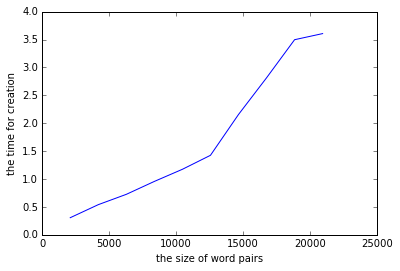

In [9]:
import matplotlib.pyplot as plt
import time
test_case = 10
word_pair_length = len(word_pair)
step = word_pair_length / test_case

duration = []
sizeofword = []

for idx in xrange(0, test_case):
    sub_pair = word_pair[: (idx + 1) * step]

    startTime = time.time()
    translation_matrix.TranslationMatrix(sub_pair, source_word_vec, target_word_vec)
    endTime = time.time()
    
    sizeofword.append(len(sub_pair))
    duration.append(endTime - startTime)

plt.plot(sizeofword, duration)
plt.xlabel("the size of word pairs")
plt.ylabel("the time for creation")
plt.show()